<center><img src=https://github.com/nccr-itmo/FEDOT/raw/master/docs/fedot_logo.png></img></center>

# <center>Решение задачи предсказания временных рядов при помощи фреймворка [FEDOT](https://github.com/nccr-itmo/FEDOT)</center>

## Введение

Для решения любой задачи при помощи методов машинного обучения, исследователю требуется пройти множество шагов: от предобработки данных, выбора наиболее качественных признаков, преобразования признаков, подбора модели и до настройка гиперпараметров для запуска.

Концепция задач **автоматического машинного обучения (AutoML)** направлена на уменьшении (или даже в полном исключении) участия человека в процессе решения задач машинного обучения. На основе доступных данных (обучающей выборки) осуществляется поиск оптимального **пайплайна** (последовательности действий над данными и моделей для предсказания) для наиболее лучшего решения задачи.

<center><img src=https://habrastorage.org/r/w1560/webt/5r/9t/sd/5r9tsdb-inbszzrmy_jnmpphiwe.png></img></center>

**FEDOT** - это фреймворк с открытым исходным кодом автоматического машинного обучения, который способен автоматизировать создание и оптимизацию пайплайнов машинного обучения и их элементов. 
Фреймворк позволяет компактно и эффективно решать различные задачи моделирования.


Наш [GitHub](https://github.com/nccr-itmo/FEDOT)

### Краткое замечание по установке FEDOT

Наиболее простой способ установки фреймворка **FEDOT** через `pip`:

In [ ]:
# !pip install fedot

Однако, на данный момент, мы рекомендуем вам его установить напрямую из master ветки репозитория:

In [1]:
!pip install --upgrade --force-reinstall --no-cache-dir --quiet --no-warn-script-location https://github.com/nccr-itmo/FEDOT/archive/master.zip

<div class="alert alert-block alert-info"><b>Примечание</b>: существуют альтернаитвные способы установки, с которыми можно ознакомится в разделе <b><a href="https://fedot.readthedocs.io/en/latest/introduction/tutorial/quickstart.html">Quickstart</a></b> в нашей документации.</div>

## Данные

В качестве примера задачи предсказания временных рядов возьмем реальные данные из датасета [Sea level daily gridded data from satellite altimetry for the global ocean from 1993 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview). Для задачи был подготовлен временной ряд с суточным показателем высоты над поверхности моря над средним значением поверхности геоида. Набор состоит из трех признаков:
* Время
* Уровень - высота поверхности моря в точке с координатами 10°N 120°W (WGS84), м;
* Соседний уровень - высота поверхности моря в точке с координатами 10°N 121°W (WGS84), м.

Впервую очередь, необходимо загрузить данные из нашего репозитория:

In [2]:
!wget https://raw.githubusercontent.com/ITMO-NSS-team/fedot-examples/main/notebooks/data/ts_sea_level.csv

--2022-09-12 16:26:40--  https://raw.githubusercontent.com/ITMO-NSS-team/fedot-examples/main/notebooks/data/ts_sea_level.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121874 (119K) [text/plain]
Saving to: ‘ts_sea_level.csv’

ts_sea_level.csv    100%[===================>] 119.02K  --.-KB/s    in 0.07s   

2022-09-12 16:26:40 (1.60 MB/s) - ‘ts_sea_level.csv’ saved [121874/121874]



Сперва взглянем на данные и отрисуем временной ряд

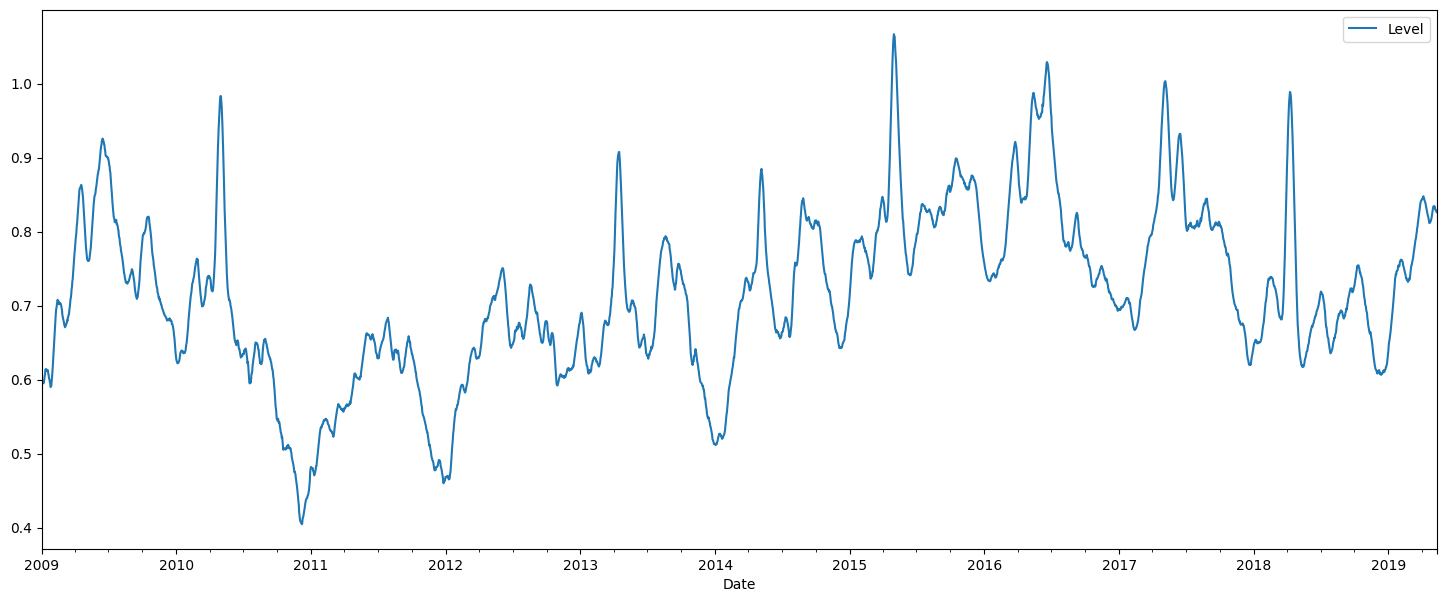

Длинна временного ряда - 3784


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

timeseries_df = pd.read_csv('ts_sea_level.csv')
timeseries_df['Date'] = pd.to_datetime(timeseries_df['Date'])

timeseries_df.plot('Date', 'Level')
plt.show()

print(f'Длинна временного ряда - {len(timeseries_df)}')

Выделим часть из этого ряда, которую мы хотим предсказать, и позже сверим ее с реальными значениями

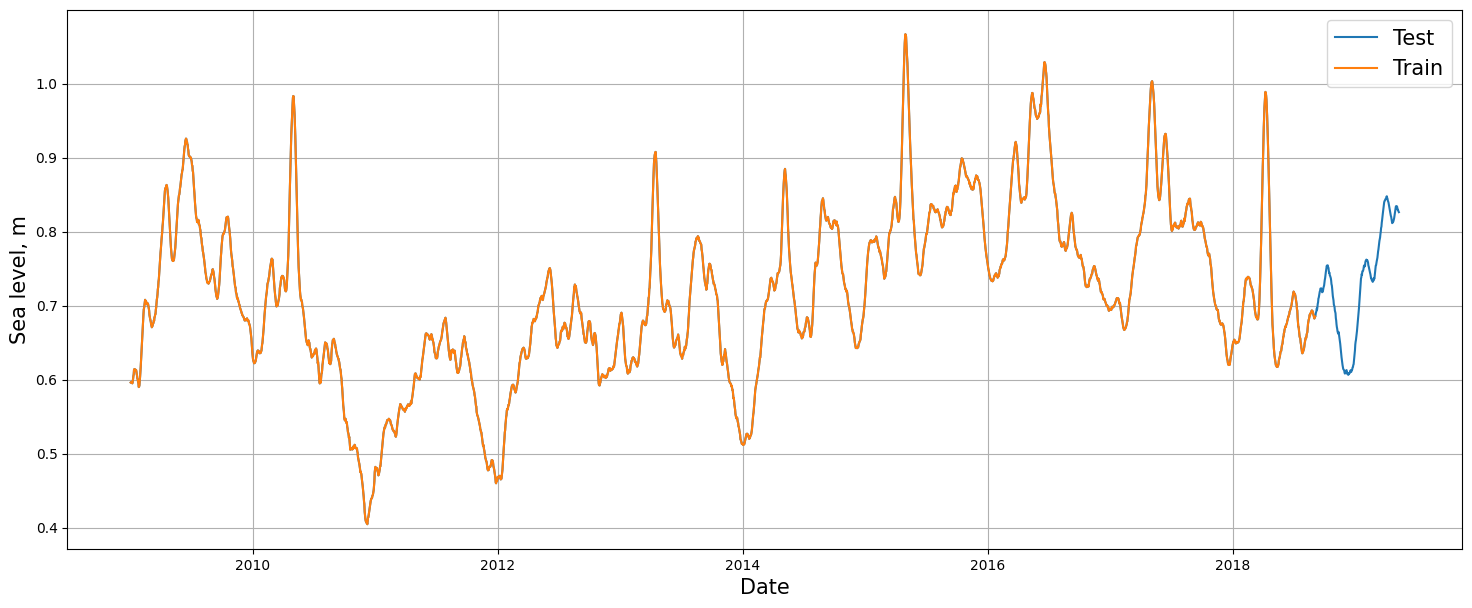

In [3]:
len_forecast = 250

true_values = np.array(timeseries_df['Level'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

plt.plot(timeseries_df['Date'], true_values, label = 'Test')
plt.plot(timeseries_df['Date'][:-len_forecast], train_array, label = 'Train')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

В этом туториале данные для обучения мы обернем в объекты используемые внутри фреймворка **FEDOT** в `InputData()`. В первую очередь, импортируем необхдимое из фреймворка:

In [12]:
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

Начнем с объявления решаемой задачи. В прошлых туториалах при использовании API мы указывали на тип решаемой задачи. Например, для классификации мы указывали `'classification'`. В дальнейшем во время работы фреймворка он оборачивался в такую структуру как `Task()`. В этом туториале мы сделаем это собственоручно.

В объект `Task()` мы указываем тип решаемой задачи `TaskTypesEnum.ts_forecasting` (предсказание времянных рядов) и передадим необходимые парамметры для этого типа задачи, в нашем случае длину предсказания.

task_parameters = TsForecastingParams(forecast_length=len_forecast)

task = Task(TaskTypesEnum.ts_forecasting, task_parameters)

Далее из кусочков соберем данные в `InputData()`:
* `idx` - переменная, которая хранит индексы данных;
* `features` - переменная, которая хранит данные из признаков
* `target` - переменная, которая хранит значения целевой переменной. В случае задачи предсказания времянных рядов, она дублирует значения features
* `task` - хранит значения задачи, которую предстоит решать фреймворку
* `data_type` - хранит значение типа данных

In [ ]:
features = np.array(timeseries_df['Level'])

input_data = InputData(
    idx=np.arange(0, len(features)),
    features=features,
    target=features,
    task=task,
    data_type=DataTypesEnum.ts
)

В конце, разобьем данные для обучения и предсказания

In [ ]:
train_input, predict_input = train_test_data_setup(input_data)

Теперь мы можем приступить к прогнозированию при помощи FEDOT

## Решение при помощи FEDOT

In [13]:
from fedot.api.main import Fedot
from fedot.core.repository.tasks import TsForecastingParams

auto_model = Fedot(
    problem='ts_forecasting',
    task_params=task_parameters,
    timeout=40
)

In [14]:
pipeline = auto_model.fit(features=train_input)

2022-09-14 18:04:56,079 - AssumptionsHandler - Initial pipeline fitting started
2022-09-14 18:04:58,789 - AssumptionsHandler - Initial pipeline was fitted successfully
2022-09-14 18:04:58,815 - DataSourceSplitter - Shuffling data for time-series: possibly incorrect use!
2022-09-14 18:04:58,821 - DataSourceSplitter - K-folds cross validation is applied.


Generations:   1%|          | 1/100 [00:00<?, ?gen/s]

2022-09-14 18:04:58,831 - MultiprocessingDispatcher - Number of used CPU's: 1
2022-09-14 18:05:20,545 - EvoGraphOptimizer - Generation num: 1
2022-09-14 18:05:20,552 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [(0.11116200010046433, 0.20000000000000004)]
2022-09-14 18:05:20,554 - EvoGraphOptimizer - no improvements for 0 iterations
2022-09-14 18:05:20,555 - EvoGraphOptimizer - spent time: 0.4 min
2022-09-14 18:05:20,914 - MultiprocessingDispatcher - Number of used CPU's: 1
2022-09-14 18:05:37,557 - PipelineObjectiveEvaluate - Continuing after pipeline fit error <y must be a 1d array> for graph: (((((/n_sparse_lagged_{'window_size': 10, 'n_components': 0.5, 'sparse_transform': True, 'use_svd': False};)/n_stl_arima_default_params;;/n_glm_{'family': 'gaussian', 'link': 'identity'};)/n_lasso_default_params;;/n_sparse_lagged_{'window_size': 10, 'n_components': 0.5, 'sparse_transform': True, 'use_svd': False};)/n_decompose_default_params;)/n_linear_default_params;;((/

Generations:   1%|          | 1/100 [03:37<?, ?gen/s]

2022-09-14 18:08:36,081 - OptimisationTimer - Composition time: 3.621 min
2022-09-14 18:08:36,082 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-09-14 18:08:36,084 - GPComposer - GP composition finished


  2%|▏         | 15/1000 [01:24<1:32:55,  5.66s/trial, best loss: 0.10731404872016846]


2022-09-14 18:13:49,222 - OperationTypesRepository - Operation lagged not found in the repository


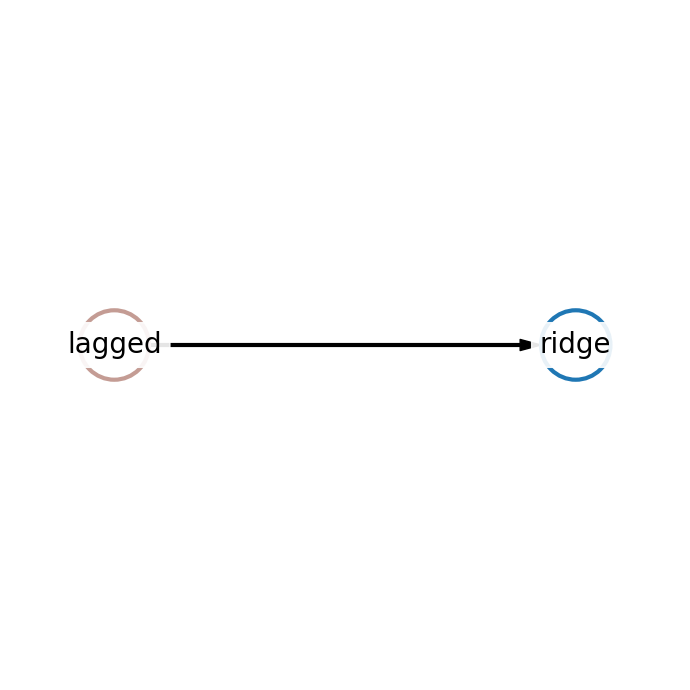

In [16]:
pipeline.show(node_size_scale=0.5, dpi=100)

In [18]:
forecast = auto_model.predict(predict_input)

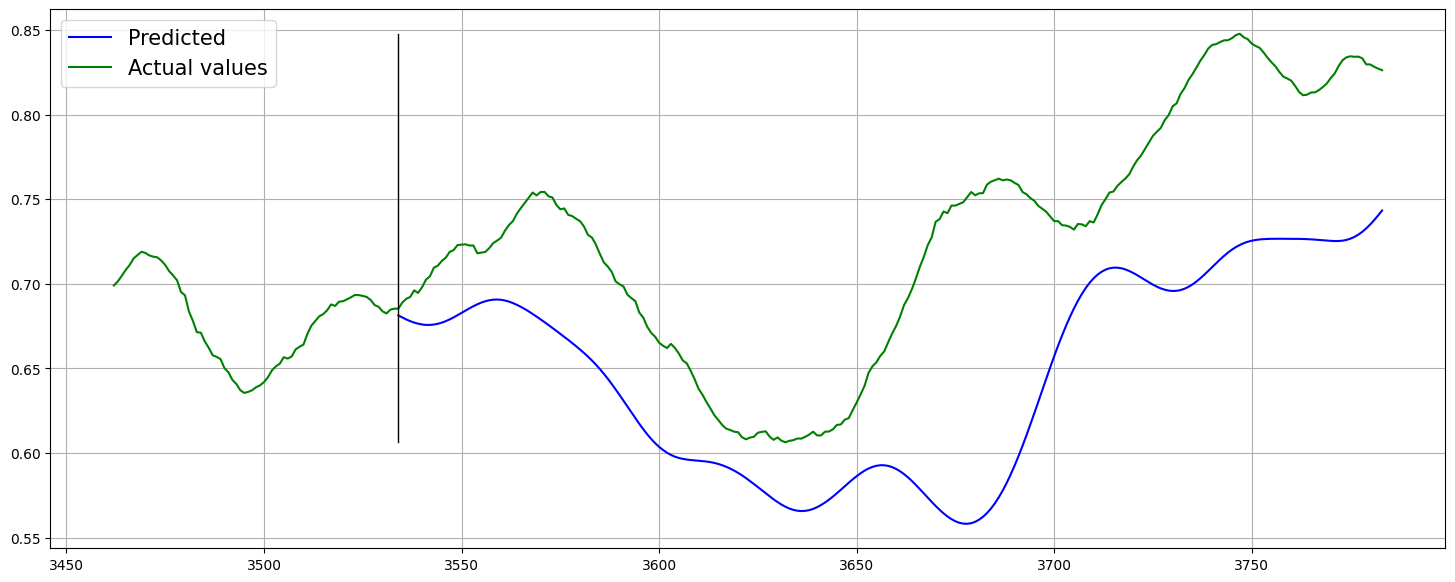

In [20]:
auto_model.plot_prediction()

Для сохранения истории процесса генераци в формате JSON воспользуемся следующей командой

In [21]:
auto_model.history.save();

## Послесловие

В данном блокноте мы показали вам как запустить фреймворк **FEDOT** для решения задачи классификации при помощи API. Как можно было заметить, для этого потребовалось совсем немного строк кода.

Теперь и вы можете попробовать запустить фреймворк автоматического машинного обучения **FEDOT** на своих данных.

<i class="fa fa-github" style="font-size:24px"></i> - <a href="https://github.com/nccr-itmo/FEDOT"> Наш репозиторий </a>

<i class="fa fa-telegram" style="font-size:24px;color:blue"></i> - <a href="https://t.me/FEDOT_helpdesk">Telegram канал поддержки</a>

<i class="fa fa-youtube-play" style="font-size:24px;color:red"></i> - <a href="https://www.youtube.com/channel/UC4K9QWaEUpT_p3R4FeDp5jA">Наш канал на Youtube</a>